## 9.7 单发多框检测（SSD）
### 9.7.1 模型

原作者写的mxnet代码太过于混乱难以阅读且效率低下，这里采用Keras的经典结构进行重构。
并针对Keras框架特性进行优化：
1. Anchors只生成一次，不需要跟随网络使用GPU运算。并且在模型中可以看作是一个常量，无需从网络中计算得出。
2. 喂入的数据y_true就已经可以根据anchors计算出每个anchors的标注和偏移，不需要在loss中再计算，这样影响GPU计算图效率。

In [2]:
%matplotlib inline
import d2lzh as d2l
import tensorflow as tf
tf.enable_eager_execution()
from tensorflow import keras
import numpy as np
from PIL import Image

#### 9.7.1.6 完整的模型

In [3]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79], [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

In [4]:
class TinySSD(keras.Model):
    def __init__(self, num_classes):
        self.num_classes = num_classes
        inputs = keras.Input((256, 256, 3))

        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5

        x = self.base_net(inputs)
        anchors[0] = d2l.MultiBoxPrior(x, sizes=sizes[0], ratios=ratios[0])
        cls_preds[0] = self.cls_predictor(num_anchors, num_classes)(x)
        bbox_preds[0] = self.bbox_predictor(num_anchors)(x)

        x = self.down_sample_blk(128, x)
        anchors[1] = d2l.MultiBoxPrior(x, sizes=sizes[1], ratios=ratios[1])
        cls_preds[1] = self.cls_predictor(num_anchors, num_classes)(x)
        bbox_preds[1] = self.bbox_predictor(num_anchors)(x)

        x = self.down_sample_blk(128, x)
        anchors[2] = d2l.MultiBoxPrior(x, sizes=sizes[2], ratios=ratios[2])
        cls_preds[2] = self.cls_predictor(num_anchors, num_classes)(x)
        bbox_preds[2] = self.bbox_predictor(num_anchors)(x)

        x = self.down_sample_blk(128, x)
        anchors[3] = d2l.MultiBoxPrior(x, sizes=sizes[3], ratios=ratios[3])
        cls_preds[3] = self.cls_predictor(num_anchors, num_classes)(x)
        bbox_preds[3] = self.bbox_predictor(num_anchors)(x)

        x = keras.layers.GlobalMaxPool2D()(x)
        x = keras.layers.Reshape((1, 1, 128))(x)
        anchors[4] = d2l.MultiBoxPrior(x, sizes=sizes[4], ratios=ratios[4])
        cls_preds[4] = self.cls_predictor(num_anchors, num_classes)(x)
        bbox_preds[4] = self.bbox_predictor(num_anchors)(x)

        self.anchors = np.concatenate(anchors, axis=1)  # Not in graphic

        self.cls_preds = self.concat_preds(cls_preds)
        self.cls_preds = keras.layers.Reshape((-1, num_classes + 1))(self.cls_preds)
        self.cls_preds = keras.layers.Softmax(name='cls_preds')(self.cls_preds)
        self.bbox_preds = self.concat_preds(bbox_preds, name='bbox_preds')

        print('cls_preds shape = ', self.cls_preds.shape)   # (b, an, clz+1)
        print('bbox_preds shape = ', self.bbox_preds.shape)   # (b, an * 4)

        super().__init__(
            inputs=inputs,
            outputs=(self.cls_preds, self.bbox_preds),
            name='TinySSD')

    def get_anchors(self):
        return self.anchors

    # 类别预测层
    @staticmethod
    def cls_predictor(num_anchors, num_classes):
        return keras.layers.Conv2D(num_anchors * (num_classes + 1), kernel_size=3, padding='same')

    # 边界框预测层
    @staticmethod
    def bbox_predictor(num_anchors):
        return keras.layers.Conv2D(num_anchors * 4, kernel_size=3, padding='same')

    # 连结多尺度的预测
    @staticmethod
    def concat_preds(preds, name=None):
        def flatten_pred(pred):
            return keras.layers.Flatten()(pred)

        return keras.layers.Concatenate(axis=1, name=name)([flatten_pred(p) for p in preds])

    # 高和宽减半块
    @staticmethod
    def down_sample_blk(num_channels, x):
        for _ in range(2):
            x = keras.layers.Conv2D(num_channels, kernel_size=3, padding='same')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.ReLU()(x)
        x = keras.layers.MaxPool2D(2)(x)
        return x

    # 基础网络块
    def base_net(self, x):
        for num_filters in [16, 32, 64]:
            x = self.down_sample_blk(num_filters, x)
        return x

##%%

net = TinySSD(num_classes=1)
#net.summary()

cls_preds shape =  (?, ?, 2)
bbox_preds shape =  (?, 21776)


In [5]:
Y1 = net.cls_predictor(5, 10)(np.zeros((2, 20, 20, 8)))
Y2 = net.cls_predictor(3, 10)(np.zeros((2, 10, 10, 16)))
(Y1.shape, Y2.shape)

(TensorShape([Dimension(2), Dimension(20), Dimension(20), Dimension(55)]),
 TensorShape([Dimension(2), Dimension(10), Dimension(10), Dimension(33)]))

In [6]:
net.concat_preds([Y1, Y2]).shape

TensorShape([Dimension(2), Dimension(25300)])

In [7]:
net.down_sample_blk(10, np.zeros((2, 20, 20, 3), dtype='float32')).shape

TensorShape([Dimension(2), Dimension(10), Dimension(10), Dimension(10)])

In [8]:
net.base_net(np.zeros((2, 256, 256, 3), dtype='float32')).shape

TensorShape([Dimension(2), Dimension(32), Dimension(32), Dimension(64)])

In [9]:
X = np.zeros((32, 256, 256, 3), dtype='float32')
cls_preds, bbox_preds = net.predict(X)
anchors = net.get_anchors()

#print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output class preds: (32, 5444, 2)
output bbox preds: (32, 21776)


### 9.7.2 训练模型
#### 9.7.2.1 读取数据集和初始化

In [10]:
batch_size = 32
train_iter, val_iter = d2l.load_data_pikachu(anchors, batch_size)

# x, y = train_iter.getitem()
# print(y.shape)

Found 900 validated image filenames.
Found 100 validated image filenames.


#### 9.7.2.2 定义损失函数和评价函数

In [11]:
optimizer = keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean(name='train_loss')
val_loss = tf.keras.metrics.Mean(name='val_loss')
clz_eval = tf.keras.metrics.Mean(name='clz_eval')
loc_eval = tf.keras.metrics.Mean(name='loc_eval')


def loss_func(logits, labels):
    cls, off, mask = labels
    softmax_clz, offset_loc = logits
    loss_clz = keras.losses.sparse_categorical_crossentropy(cls, softmax_clz)
    loss_clz = tf.reduce_mean(loss_clz, axis=-1)

    off = tf.cast(off, 'float32')
    mask = tf.cast(mask, 'float32')
    offset_loc = tf.cast(offset_loc, 'float32')
    loss_loc = keras.losses.mean_absolute_error(off * mask, offset_loc * mask)
    return loss_clz + loss_loc


def cls_eval(logits, labels):
    softmax_clz, _ = logits
    cls_labels, _, _ = labels
    max = tf.argmax(softmax_clz, axis=-1)
    eq = tf.equal(max, cls_labels)
    return tf.reduce_sum(tf.cast(eq, 'int16'))


def bbox_eval(logits, labels):
    _, offset_loc = logits
    _, off_labels, mask_labels = labels
    off_labels = tf.cast(off_labels, 'float32')
    mask_labels = tf.cast(mask_labels, 'float32')
    offset_loc = tf.cast(offset_loc, 'float32')
    return tf.reduce_sum(tf.abs(((offset_loc - off_labels) * mask_labels)))


@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        logits = net(images)
        loss = loss_func(logits, labels)
    gradients = tape.gradient(loss, net.trainable_variables)
    optimizer.apply_gradients(zip(gradients, net.trainable_variables))
    train_loss(loss)
    clz_eval(cls_eval(logits, labels))
    loc_eval(bbox_eval(logits, labels))


@tf.function
def val_step(images, labels):
    logits = net(images)
    t_loss = loss_func(logits, labels)
    val_loss(t_loss)

#### 9.7.2.3 训练模型

In [12]:
for epoch in range(10):
    for images, [cls, off, mask] in train_iter:
        train_step(images, [cls, off, mask])
    for images, [cls, off, mask] in val_iter:
        val_step(images, [cls, off, mask])

    template = 'Epoch {}, Loss: {}, Class Accuracy: {}, BBox Accuracy: {}, Test Loss: {}'
    print(template.format(epoch + 1,
                          train_loss.result(),
                          clz_eval.result(),
                          loc_eval.result(),
                          val_loss.result()))
    # Reset the metrics for the next epoch
    train_loss.reset_states()
    clz_eval.reset_states()
    loc_eval.reset_states()
    val_loss.reset_states()
        

Epoch 1, Loss: 0.13853125274181366, Class Accuracy: -19593.5859375, BBox Accuracy: 890.5908813476562, Test Loss: 0.0078970268368721
Epoch 2, Loss: 0.005293987225741148, Class Accuracy: -20943.96484375, BBox Accuracy: 324.5875549316406, Test Loss: 0.004797531757503748
Epoch 3, Loss: 0.003552907146513462, Class Accuracy: -20949.96484375, BBox Accuracy: 279.0857238769531, Test Loss: 0.004427872132509947
Epoch 4, Loss: 0.0028829274233430624, Class Accuracy: -20953.03515625, BBox Accuracy: 230.2688446044922, Test Loss: 0.0028363014571368694
Epoch 5, Loss: 0.0025734552182257175, Class Accuracy: -20954.482421875, BBox Accuracy: 211.99716186523438, Test Loss: 0.0027393982745707035
Epoch 6, Loss: 0.002291953656822443, Class Accuracy: -20953.03515625, BBox Accuracy: 186.00753784179688, Test Loss: 0.0022330614738166332
Epoch 7, Loss: 0.0021133525297045708, Class Accuracy: -20952.345703125, BBox Accuracy: 179.43014526367188, Test Loss: 0.002525635762140155
Epoch 8, Loss: 0.0019304999150335789, Cla

### 9.7.3 预测

In [13]:
img = Image.open('../img/pikachu.jpg')
img = np.array(img.resize((256, 256)))
imgs = np.expand_dims(img, axis=0)
print(imgs.shape)

(1, 256, 256, 3)


In [14]:
def predict(x):
    cls_preds, bbox_preds = net.predict(x)
    a = cls_preds.argmax(axis=-1)
    print('pi:', np.argwhere(a == 1))
    loc = d2l.offset_to_loc(anchors, cls_preds, bbox_preds)
    output = d2l.NMS(cls_preds, loc, threshold=0.5)
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]

output = predict(imgs)
print(output.shape)

pi: [[   0 2407]
 [   0 2467]
 [   0 2504]
 [   0 2508]
 [   0 2596]]
(3, 6)


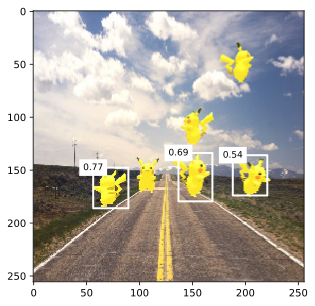

In [15]:
d2l.set_figsize((5, 5))

def display(img, output, threshold):
    fig = d2l.plt.imshow(img)
    for row in output:
        score = row[1]
        if score < threshold:
            continue
        h, w = img.shape[0:2]
        bbox = [row[2:6] * np.array((w, h, w, h))]
        d2l.show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')

display(img, output, threshold=0.3)